In [38]:
from functools import partial, reduce
from typing import TypedDict, Optional
from collections import ChainMap

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import pandas as pd
from IPython.display import HTML

from itertools import chain, combinations

In [39]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [40]:
def balanced_bernouli(P):
    ps = list(powerset(range(P)))
    while True:
        order = np.random.choice(len(ps), len(ps), False)
        for i in order:
            s = np.ones(P)
            s[list(ps[i])] = -1
            yield s

In [41]:
def ak_gain(k, a0=1e-2, A=1000, alpha=0.602):
    """Rule of thumb, A ~ <=10% max iterations expected
    a0 to be smallest of desired changes among theta early on"""
    a = a0 * (1 + A) ** alpha
    return a / (k + 1 + A) ** alpha


def ck_gain(k, c=1e-2, gamma=0.101):
    """Rule of thumb, c ~ std loss noise (e in y = L + e)"""
    return c / (k + 1) ** gamma


def bernouli_sample(p):
    while True:
        proba = np.random.rand(p)
        values = (proba < 0.5).astype(int) * 2 - 1
        yield values

def segmented_uniform_sample(p, width=1.0):
    while True:
        proba = np.random.rand(p)

        values = (proba < 0.5).astype(int) * 2 - 1  # if proba < 0.5, value is 1

        yield (proba + 0.5) * width * values


def approx_gradient(loss, perturb, theta, c):
    # SPSA
    diff = loss(theta + c * perturb) - loss(theta - c * perturb)
    return (diff / (2 * c)) / perturb


def optim_spsa(theta_0, loss_fnc, ak_gen, ck_gen, max_theta_diff=0.1, num_approx=1, perturb_gen=None):
    theta = theta_0
    P = len(theta)
    k = 0
    if perturb_gen is None:
        perturb_gen = bernouli_sample(P)
    while True:
        ak = ak_gen(k)
        ck = ck_gen(k)
        grads = []
        for i, perturb in zip(range(num_approx), perturb_gen):
            grad_i = approx_gradient(loss_fnc, perturb, theta, ck)
            grads.append(grad_i)
        grad = np.mean(grads, axis=0)
        assert grad.shape == theta.shape, grad.shape
        theta_diff = ak * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > max_theta_diff:
            theta_diff *= max_theta_diff / theta_diff_mag
        theta = theta - theta_diff
        yield theta



In [42]:
next(segmented_uniform_sample(2))

array([-1.41154775, -1.14040591])

In [43]:
# simple thing is 'root' finding, where loss is just the current value, and theta is x
goal_theta = np.array([1, 1])

def simple_loss(theta):
    diff = np.asarray(theta) - goal_theta
    return np.sqrt(diff@diff)

theta_0 = np.array([0.5, 1.5])

optim = optim_spsa(theta_0, simple_loss, ak_gain, ck_gain)

In [44]:
for i, theta in zip(range(100), optim):
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.7071067811865476
10: 0.587106781186547
20: 0.46710678118654647
30: 0.2671067811865456
40: 0.1671067811865452
50: 0.08710678118654486
60: 0.027106781186544596
70: 0.00020920410530624538
80: 2.5508902623735556e-06
90: 7.509119828043987e-08


In [45]:
theta

array([1., 1.])

In [46]:
thetas = []
optim = optim_spsa(theta_0, simple_loss, partial(ak_gain, a0=1, A=1), partial(ck_gain, c=1e-2))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.6071067811865475
10: 0.007106781186547256
20: 0.007106781758488198
30: 0.010152613521156395
40: 0.13126929040392946
50: 0.13126929040392946
60: 0.13126929040392946
70: 0.010152613521156395
80: 0.13126929040392946
90: 0.13126929040392946


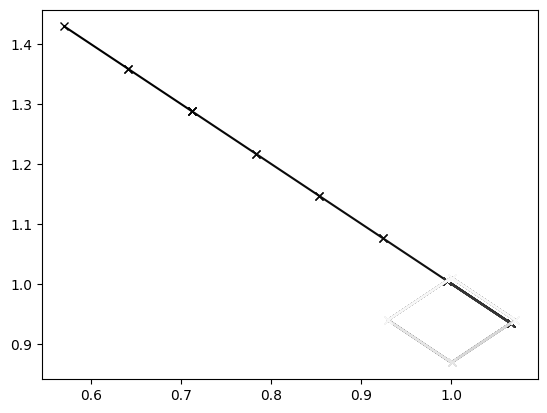

In [47]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")

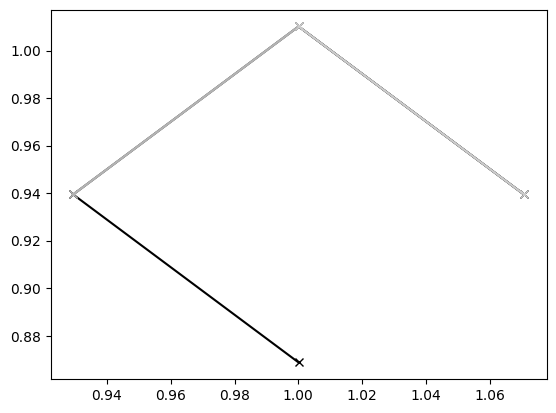

In [48]:
num_segments = 10
for i in range(10 - 1):
    x1, y1 = thetas[-10 + i]
    x2, y2 = thetas[-10 + i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")

In [49]:
# simple thing is 'root' finding, where loss is just the current value, and theta is x
goal_theta = np.array([1, 1])

def noise_source(noise_scale=1e-3):
    return np.random.normal(0, noise_scale, size=len(goal_theta))

def noisy_loss(theta, noise_scale=1e-3, v=None):
    if v is None:
        v = noise_source(noise_scale)
    diff = np.asarray(theta) - goal_theta + v
    return np.sqrt(diff@diff)

theta_0 = np.array([0.5, 1.5])

In [50]:
thetas = []
optim = optim_spsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.1, A=10), partial(ck_gain, c=1e-2), num_approx=1, perturb_gen=balanced_bernouli(2))
for i, theta in zip(range(50), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.714142842854285
10: 0.8315175020631312
20: 0.45358122898558256
30: 0.6366572234450127
40: 0.9596806766178154


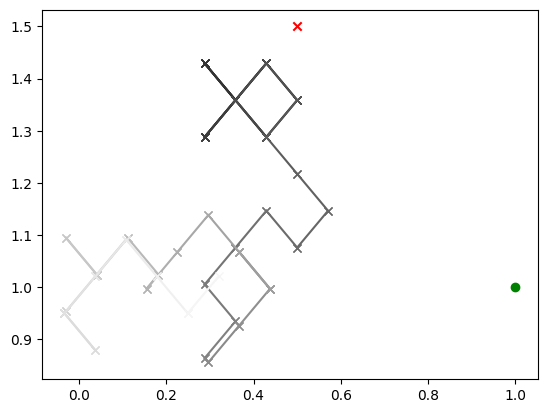

In [51]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

In [52]:
thetas = []
optim = optim_spsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.1, A=10), partial(ck_gain, c=0.5))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.7075068590753399
10: 0.40791722977498684
20: 0.03748482211684295
30: 0.029788541183754798
40: 0.07073404321801897
50: 0.023019319552786337
60: 0.021756310120552205
70: 0.08397369954170257
80: 0.030498735499828247
90: 0.04543301671257187


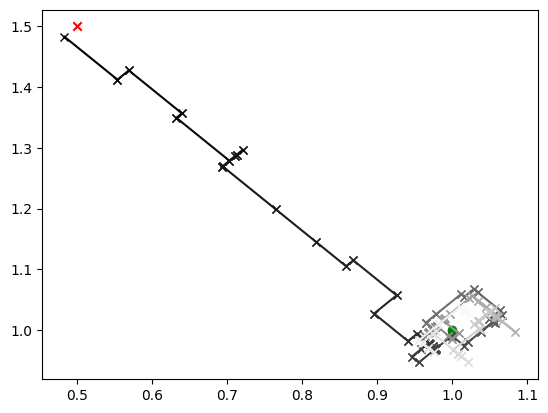

In [53]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

In [54]:
thetas = []
optim = optim_spsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.001, A=20), partial(ck_gain, c=0.01))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

0: 0.7071138002524888
10: 0.7097975617643592
20: 0.7000949730366932
30: 0.705844749351048
40: 0.6740040053664128
50: 0.6722302511525161
60: 0.6661405129465897
70: 0.6641135436142631
80: 0.6709752287627814
90: 0.6558268662086254


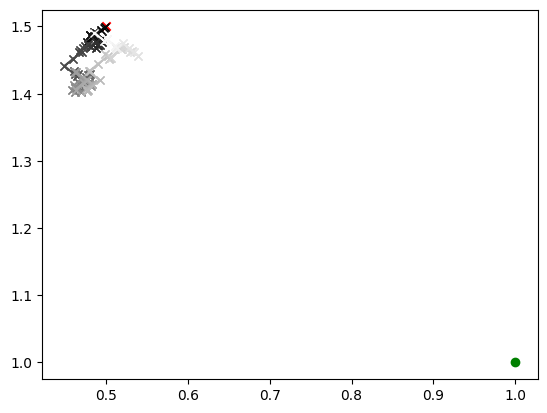

In [55]:
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

0: 0.71508930631454
10: 0.39679459032636943
20: 0.6475446422989729
30: 0.569951314504325
40: 0.866475188236192
50: 0.5512430939138725
60: 0.6413063106389897
70: 0.6617213396782775
80: 0.5938626028811229
90: 0.4086484356458546


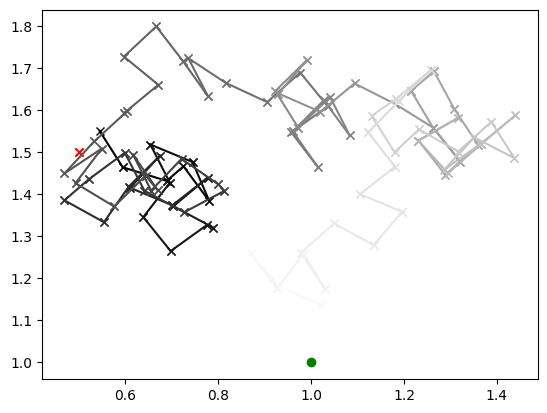

In [56]:
thetas = []
optim = optim_spsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.1, A=10), partial(ck_gain, c=1e-2), perturb_gen=segmented_uniform_sample(2))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

0: 0.652227115845429
10: 0.15617136034674045
20: 0.028077256305894437
30: 0.09182370812053021
40: 0.0525486467416853
50: 0.04114403846914073
60: 0.07729819231550185
70: 0.0632030309637455
80: 0.026596469618366092
90: 0.04591161716437159


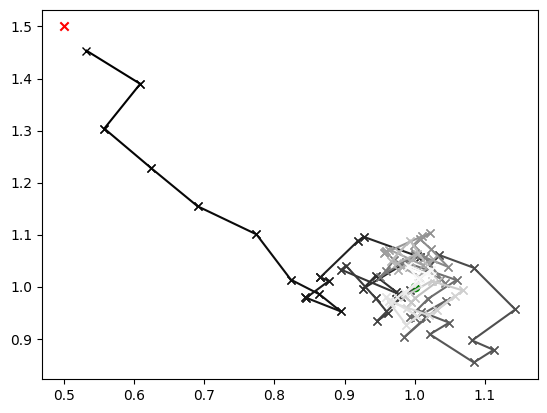

In [57]:
thetas = []
optim = optim_spsa(theta_0, partial(noisy_loss, noise_scale=1e-1), partial(ak_gain, a0=0.05, A=10), partial(ck_gain, c=1e-1), perturb_gen=segmented_uniform_sample(2))
for i, theta in zip(range(100), optim):
    thetas.append(theta)
    if i % 10 == 0:
        print(f"{i}: {simple_loss(theta)}")

num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

In [58]:
def test():
    return (1, )

a,  = test()
a

1

In [59]:

# def approx_gradient(loss, perturb, theta, c):
#     # SPSA
#     diff = loss(theta + c * perturb) - loss(theta - c * perturb)
#     return (diff / (2 * c)) / perturb

class SPSA_Params(TypedDict):
    a0: float
    c0: float
    A: int
    gamma: float  # 0.101
    alpha: float # 0.602
    max_delta_theta: float  # normalize
    max_iter: int
    t0: float
    num_approx: int


# a = a0 * (1 + A) ** alpha
# return a / (k + 1 + A) ** alpha

class OptimSPSA:
    _default_params: SPSA_Params = {"gamma": 0.101, "alpha": 0.602, "t0": .5, "num_approx": 1} 
    _required_params = {"max_iter", "max_delta_theta"}
    _params: SPSA_Params
    def __init__(self, theta_0, loss_fnc, v_fnc=None, blocking=False, perturb_gen=None, **params):
        self._params = dict(ChainMap(params, self._default_params))
        assert len(self._required_params - set(self._params)) == 0, self._required_params
        self.theta_0 = np.asarray(theta_0)
        self.blocking = blocking
        self.loss = loss_fnc
        self.v_fnc = v_fnc
        self._all_loss_history = []
        self._loss_history = []
        self._used_thetas = []
        self._block_history = []
        self._grad_history = []
        self.thetas = [self.theta_0]
        self.k = 0
        if perturb_gen is None:
            self._perturb_gen = bernouli_sample(len(self.theta_0))
        else:
            self._perturb_gen = perturb_gen(len(self.theta_0))
        self._c_guess = self._params.get("c0")
    
    def reset(self):
        self._all_loss_history = []
        self._loss_history = []
        self._used_thetas = []
        self._block_history = []
        self._grad_history = []
        self.thetas = [self.theta_0]
        self.k = 0
    
    def calibrate(self, debug=False):
        self._params["A"] = self._params["max_iter"] * 0.13
        self._params["c0"] = self._approximate_c(c_guess = self._c_guess)
        # approximate grad, and take magnitude...
        self._params["a0"] = self._approximate_a(self._params["max_delta_theta"])
        if debug:
            print("After calibration: ", self._params)
    
    def _get_loss(self, theta, v=None):
        loss = self.loss(theta, v=v)
        self._all_loss_history.append(loss)
        self._used_thetas.append(theta)
        return loss
    
    def _approximate_a(self, max_delta_theta, num_approx=10):
        approx_grad = np.mean([self.approx_grad() for i in range(num_approx)], axis=0)
        # |a / (k + 1 + A) ** alpha * grad| = max_delta_theta
        max_grad = np.abs(approx_grad).max()
        a0 = (1 + self._params["A"])**self._params["alpha"] * max_delta_theta / max_grad
        return a0

        
    def _approximate_c(self, num_samples=10, c_guess=None):
        losses = [self._get_loss(self.theta_0) for i in range(num_samples)]
        c_est = np.std(losses, ddof=1) * 3  + 1e-10 # over-estimate it...
        if c_guess is None:
            return c_est
        # geometric mean of the guess and estimate
        return np.sqrt(c_est * c_guess)
    
    def _get_perturb(self):
        return next(self._perturb_gen)

    def approx_grad(self):
        c = self.ck(self.k)
        perturb = self._get_perturb()
        left = self.theta + c * perturb
        right = self.theta - c * perturb
        v = None
        if self.v_fnc is not None:
            v = self.v_fnc()
        diff = self._get_loss(left, v=v) - self._get_loss(right, v=v)

        grad = (diff / (2 * c)) / perturb
        self._grad_history.append(grad)
        return grad
    
    def ck(self, k):
        return self._params["c0"] / (k + 1) ** self._params["gamma"]

    def ak(self, k):
        return self._params["a0"] / (k + 1 + self._params["A"]) ** self._params["alpha"]
    
    @property
    def theta(self):
        return self.thetas[-1]

    def step(self):
        a = self.ak(self.k)
        
        for i in range(self._params["num_approx"]):
            self.approx_grad()
        grad = np.mean(self._grad_history[-self._params["num_approx"]:], axis=0)
        theta_diff = a * grad
        theta_diff_mag = np.sqrt(theta_diff @ theta_diff)
        if theta_diff_mag > self._params["max_delta_theta"]:
            theta_diff *= self._params["max_delta_theta"] / theta_diff_mag
        
        # we let it be a max... 
        loss = self.loss(self.theta - theta_diff)  # don't count it...
        block = False
        if self.blocking and self.k > 5:
            std_loss = np.std(self._loss_history[-10:])
            block = loss >= self._loss_history[-1] + std_loss * self.temp(self.k)
        self._block_history.append(block)
        if not block:
            self.thetas.append(self.theta - theta_diff)
            self._loss_history.append(loss)


        self.k += 1
        return self.theta
    
    def temp(self, k):
        return self._params["t0"] / (k + 1)**self._params["gamma"]
    
    def _print_progress(self):
        print(f"{self.k}: {self._loss_history[-1]}")

    def irun(self, num_steps=None, print_progress=True):
        if num_steps is None:
            num_steps = self._params["max_iter"]
        pi = int(num_steps // 10)
        for i in range(num_steps):
            theta = self.step()
            if print_progress and i % pi == 0:
                self._print_progress()
            yield theta
    
    def run(self, num_steps=None, print_progress=True):
        for theta in self.irun(num_steps=num_steps, print_progress=print_progress):
            pass
        return theta

    def rms_dist_from_truth(self, goal_theta):
        diffs = self.thetas - goal_theta
        rms_dist = np.sqrt(np.mean(diffs*diffs,axis=1))
        return rms_dist

    def experiment(self, num_trials, theta_history=False, goal_theta=None):
        losses = []
        dists = []
        thetas = []
        for i in range(num_trials):
            self.reset()
            self.calibrate()
            self.run()
            losses.append(self._loss_history.copy())
            if goal_theta is not None:
                dists.append(self.rms_dist_from_truth(goal_theta))
            if theta_history:
                thetas.append(self.thetas.copy())
        results = [np.array(losses).T]
        if theta_history:
            results.append(np.array(thetas).T)
        if goal_theta is not None:
            results.append(np.array(dists).T)
        return results


optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-4), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
theta = optim.run()

1: 0.5570864743956192
11: 0.05390998204741728
21: 0.06447152437993528
31: 0.048726920220074285
41: 0.0392385086508041
51: 0.03257204684123283
61: 0.02812225183629632
71: 0.025404482649513914
81: 0.021572300903454363
91: 0.020580869756939336


In [60]:
np.mean(optim.thetas[-10:], axis=0)

array([1.00508235, 1.00033394])

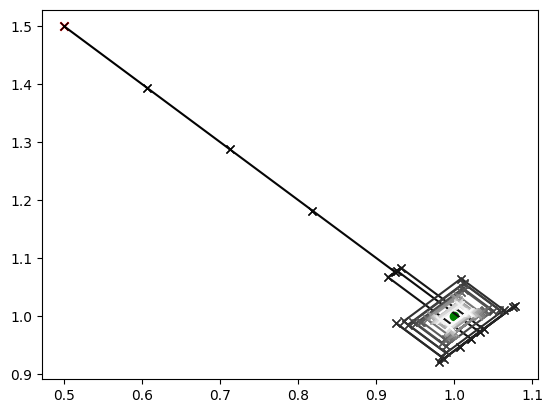

In [61]:
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

1: 0.5570900542462803
11: 0.04283834277756492
21: 0.08933979994516258
31: 0.05072426321618306
41: 0.03933533353050809
51: 0.033061934783804724
61: 0.028492617018651176
71: 0.02520762169986473
81: 0.022252309258850512
91: 0.02068209282624323


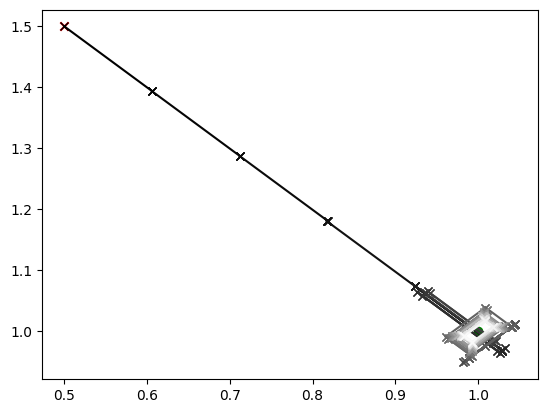

In [62]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-4), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

1: 0.7216640726088596
11: 0.21671351172868936
21: 0.08222299475722791
31: 0.20634069904388866
41: 0.1594840094815358
51: 0.11820694353599114
61: 0.12947511382096835
71: 0.1843132720289252
81: 0.017921240046844387
91: 0.14123677693661627


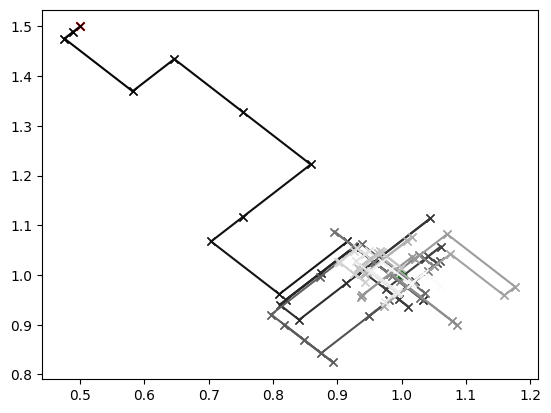

In [63]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

1: 0.5580370947413477
11: 0.07854400566372784
21: 0.20251754348259454
31: 0.09986357175814972
41: 0.13653782185035457
51: 0.10113583048982784
61: 0.08514531630252589
71: 0.055355269167970324
81: 0.06730122460979576
91: 0.12731484954894404


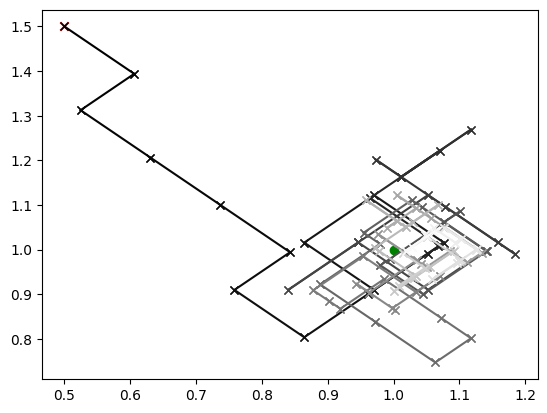

In [64]:
optim = OptimSPSA(theta_0, noisy_loss, v_fnc=partial(noise_source, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

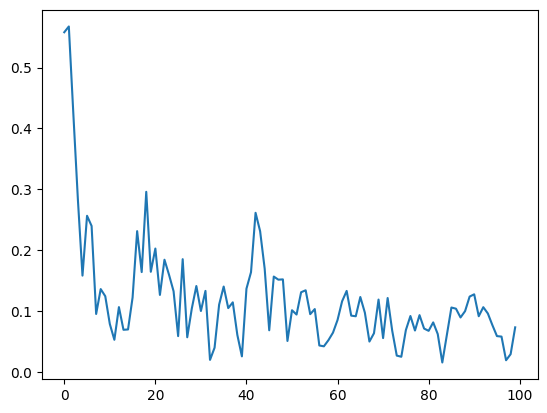

In [65]:
plt.plot(optim._loss_history)

In [66]:
noisy_loss(goal_theta, noise_scale=1e-1)

0.06359865974329411

1: 1.029945283847353
11: 0.24591302616397007
21: 0.30965126628358997
31: 0.29057593918370983
41: 0.5536881993117792
51: 0.23998228223013318
61: 0.3555848049386719
71: 0.47849481480364014
81: 0.37030562521135063
91: 0.3231824067999676
1: 0.8162519813186806
11: 0.38733871147911775
21: 0.559928621768689
31: 0.08441344544187769
41: 0.48116405436400655
51: 0.32646062016295446
61: 0.22062271548370624
71: 0.2552854853203131
81: 0.07667432928169354
91: 0.17217460673388246
1: 0.707262525399616
11: 0.2601694797651206
21: 0.3555711754351868
31: 0.255030790603993
41: 0.4666917617860798
51: 0.03868435892935136
61: 0.2756238966117386
71: 0.12994118704799792
81: 0.2620726716901482
91: 0.2282339088014138
1: 0.6368568673413948
11: 0.28864947621746084
21: 0.29076485987841616
31: 0.42442106706173877
41: 0.4406465472550285
51: 0.38168515428250366
61: 0.0819683955010368
71: 0.2633763872569039
81: 0.16064469209298213
91: 0.2353155358882361
1: 0.4070960684805735
11: 0.35123088384981627
21: 0.2718574233335852

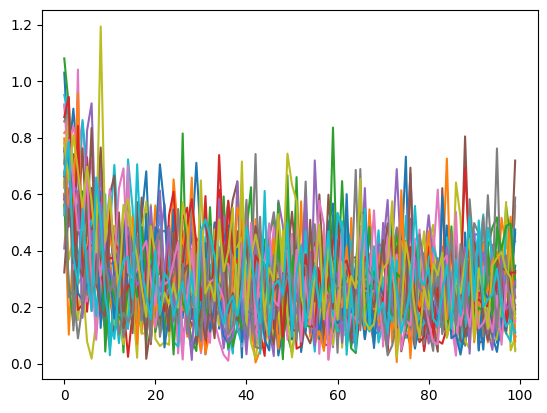

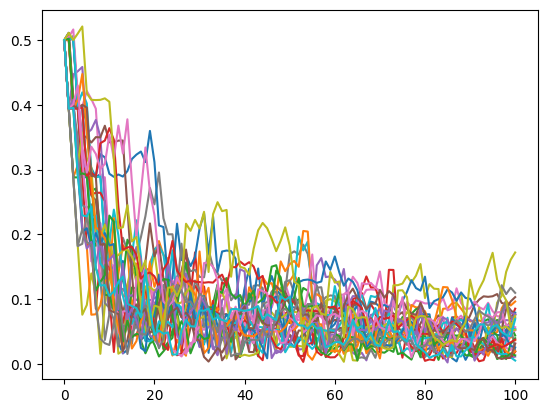

In [67]:
consts = dict(max_delta_theta=0.15, alpha=1.0, max_iter=100, c0=1e-1)
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=0.2), **consts)

losses, dists = optim.experiment(30, goal_theta=goal_theta)

# losses = []
# dists = []
# for i in range(15):
#     optim.reset()
#     optim.calibrate()
#     optim.run()
#     losses.append(optim._loss_history.copy())
#     dists.append(optim.rms_dist_from_truth(goal_theta))

# losses = np.array(losses).T
# dists = np.array(dists).T

plt.plot(losses)
plt.show()
plt.plot(dists)
plt.show()

1: 0.8322650367795069
11: 0.21916004008106418
21: 0.2119140288390564
31: 0.2941236304235629
41: 0.1019509621955856
51: 0.18566668324581542
61: 0.18848287179376946
71: 0.213701212010128
81: 0.1286321196665138
91: 0.16448575606907817
1: 0.22629384272870534
11: 0.172925730043641
21: 0.22137903131103728
31: 0.2511972105495642
41: 0.09675788978693321
51: 0.283983947552627
61: 0.25311011071186534
71: 0.3139772379622179
81: 0.1940040536355007
91: 0.35046189319207843
1: 0.526411972738267
11: 0.24987662509644862
21: 0.37086617940290484
31: 0.2620246804786337
41: 0.15506551359772042
51: 0.377346680332836
61: 0.5006378769057142
71: 0.18290935405161624
81: 0.5125740888162562
91: 0.5363199740996625
1: 0.6390875146531306
11: 0.11457850201504899
21: 0.29405383864334284
31: 0.43214536410030563
41: 0.3225802500571805
51: 0.21689679526442474
61: 0.3437296318181685
71: 0.14659465373262867
81: 0.12094553573476548
91: 0.4540020146930443
1: 0.5929963283534327
11: 0.292806304238284
21: 0.28582458267921473
31

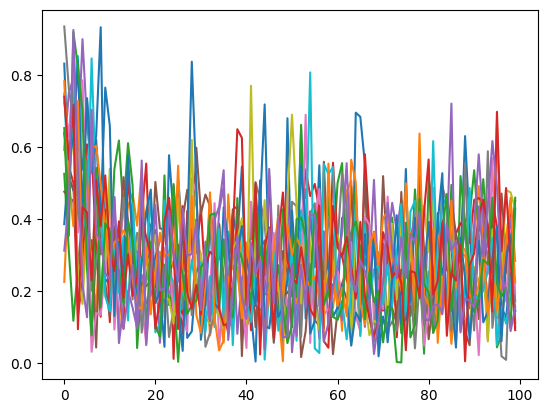

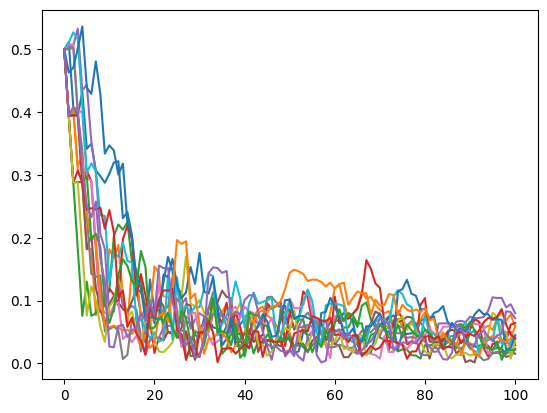

In [68]:
consts = dict(max_delta_theta=0.15, alpha=1.0, max_iter=100, c0=1e-1)
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=0.2), perturb_gen=balanced_bernouli, **consts)


losses = []
dists = []
for i in range(15):
    optim.reset()
    optim.calibrate()
    optim.run()
    losses.append(optim._loss_history.copy())
    dists.append(optim.rms_dist_from_truth(goal_theta))

losses = np.array(losses).T
dists = np.array(dists).T

plt.plot(losses)
plt.show()
plt.plot(dists)
plt.show()

In [69]:
def experiment():
    optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1.5, c0=1e-1, num_approx=30)
    optim.calibrate()
    optim.run(print_progress=False)    
    return optim._loss_history

losses = np.array(list(zip(*[experiment() for i in range(100)])))
losses.shape

(100, 100)

In [70]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-3), max_delta_theta=0.15, max_iter=100, alpha=1.5, c0=1e-1, num_approx=1)
optim.calibrate()
theta = optim.run(print_progress=False)    

In [71]:
theta

array([0.99984173, 1.00072445])

C:\Users\bobls\AppData\Local\Temp\ipykernel_30804\31005410.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 0.8)` for the same effect.

  sns.lineplot(data=df_melted, x="Time", y="Value",  ci=0.80)


<Axes: xlabel='Time', ylabel='Value'>

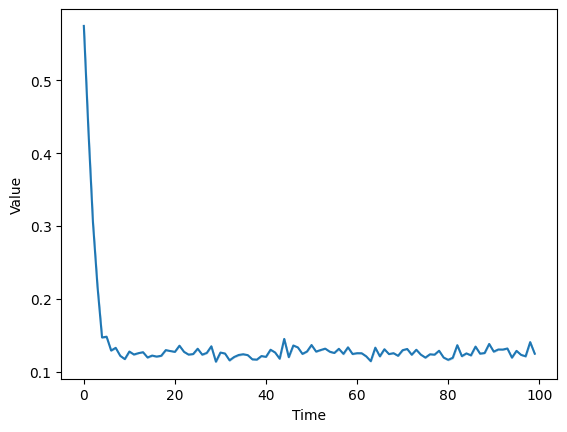

In [72]:

time_points = np.arange(losses.shape[0])
df = pd.DataFrame(losses, columns=[f"Experiment {i+1}" for i in range(losses.shape[1])])
df['Time'] = time_points
df_melted = df.melt(id_vars=['Time'], var_name='Experiment', value_name='Value')
sns.lineplot(data=df_melted, x="Time", y="Value",  ci=0.80)

1: 0.4724898387493035
11: 0.15034666757469745
21: 0.3538509651339656
31: 0.19938831942343913
41: 0.04383741074952958
51: 0.24071613211838902
61: 0.05882572421979008
71: 0.21971395262320711
81: 0.16657745149346695
91: 0.17411288948894754


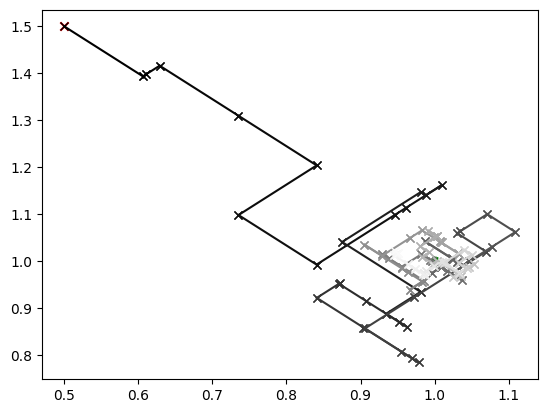

In [73]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-1), max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

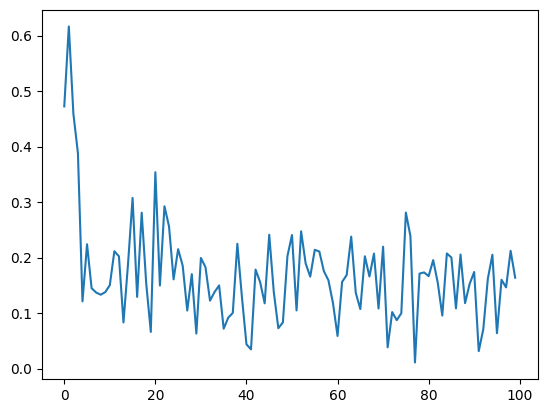

In [74]:
plt.plot(optim._loss_history)

1: 0.7273431314524302
11: 0.14068698854838654
21: 0.031318439563795826
31: 0.031318439563795826
41: 0.031318439563795826
51: 0.031318439563795826
61: 0.031318439563795826
71: 0.031318439563795826
81: 0.031318439563795826
91: 0.031318439563795826


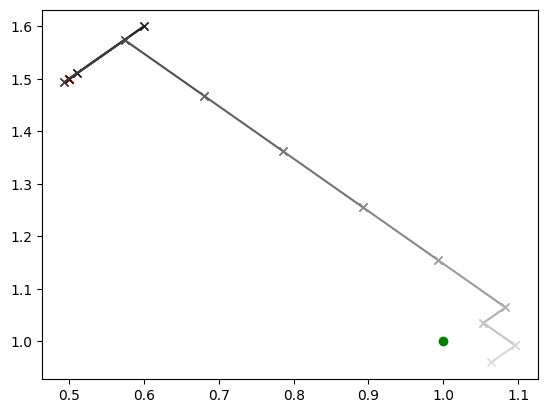

In [75]:
optim = OptimSPSA(theta_0, partial(noisy_loss, noise_scale=1e-1), blocking=True, max_delta_theta=0.15, max_iter=100, alpha=1, c0=1e-1, t0=0.01)
optim.calibrate()
optim.run()
thetas = optim.thetas
num_segments = len(thetas)
for i in range(len(thetas) - 1):
    x1, y1 = thetas[i]
    x2, y2 = thetas[i+1]
    plt.plot([x1, x2], [y1, y2], color=plt.cm.gray(i / num_segments), marker="x")
plt.scatter(*theta_0, color="r", marker="x")
plt.scatter(*goal_theta, color="g", marker="o")

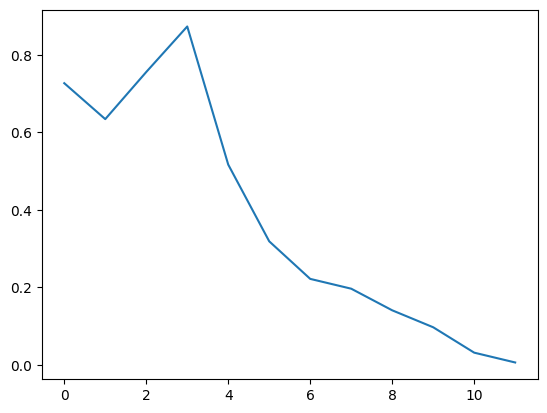

In [76]:
plt.plot(optim._loss_history)

Let's say we have an idea of the max/average distance of t0 to goal, and how noisy we expect it to be

So let's let c be estimated from the measurements, we can do N measurements at the same thing, then approximate...

You might expect that they are relatively interchangeable, but they're not really...

So we expect gradient to decrease as we get closer to 0....


In [77]:
noisy_loss(theta)

0.0010889251354523287

So say for theta0, my x is very far away, but y is close, for bernolli +1 +1 vs +1 -1 I should see a difference... 

In [78]:
theta_0 = np.array(goal_theta) + np.array([5, 0.5])
optim = OptimSPSA(theta_0, noisy_loss, max_iter=100, max_delta_theta=0.1)
optim.calibrate()
grads = [optim.approx_grad() for i in range(10)]
grads

[array([1.18736272, 1.18736272]),
 array([1.04824383, 1.04824383]),
 array([1.10651962, 1.10651962]),
 array([ 0.6067288, -0.6067288]),
 array([ 0.91424828, -0.91424828]),
 array([1.01584978, 1.01584978]),
 array([0.83101555, 0.83101555]),
 array([ 0.59673495, -0.59673495]),
 array([ 0.14247968, -0.14247968]),
 array([1.01859936, 1.01859936])]